# env init

In [1]:
import pandas
import os
import math
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC_PR
import json 
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd

def remaining_evaluate(bn, hnown_list):

    def init_belief(engine, target, hnown_list):
        # Initialize evidence
        for var in hnown_list:
        # for var in engine.BN().names():
            if var != target:
                engine.addEvidence(var, 0)

    def update_beliefs(engine, bayesNet, row, target, hnown_list):
        # Update beliefs from a given row less the Survived variable
        for var in hnown_list:
        # for var in bayesNet.names():
            if var == target:
                continue
            try:
                label = str(row.to_dict()[var])
                idx = bayesNet.variable(var).index(str(row.to_dict()[var]))
                # print(f"{bayesNet.variable(idx)=}")
                engine.chgEvidence(var, idx)
            except gum.NotFound:
                # this can happend when value is missing is the test base.
                pass        
        engine.makeInference()
        
    def is_well_predicted(engine, bayesNet, auc, row, target, hnown_list):
        update_beliefs(engine, bayesNet, row, target, hnown_list)
        marginal = engine.posterior(target)
        # print(marginal.toarray())
        outcome = row.to_dict()[target]
        # print(np.where(marginal.toarray()==np.max(marginal.toarray())))
        exp = np.mean(np.where(marginal.toarray()==np.max(marginal.toarray())))
        # exp = np.mean(np.where(marginal.toarray()>auc))
        return(exp + np.min([int(i) for i in list(bayesNet[target].labels())]) - outcome)**2
        # return 0
    results = {}
    for target in stage_list[len(hnown_list):]:
        # print(target)
        ie=gum.LazyPropagation(bn)
        init_belief(ie, target, hnown_list)
        ie.addTarget(target)
        result = test_df.apply(lambda x: is_well_predicted(ie, bn, 1/14, x, target, hnown_list), axis=1)
        # print(result)
        results[target] = result.mean()
    return results
def plot(stage_list, test_df, look_id):
    r = []
    for i in range(len(stage_list)):
        k = remaining_evaluate(bn, stage_list[:i])
        for key, value in k.items():
            k[key] = int(value)/1.0
        r.append(k)
        print(k)
    print(r)

    import matplotlib.pyplot as plt

    data = []
    look_key = list(r[0].keys())[look_id]
    for res in r:
        if look_key in res.keys() :
            data.append(res[look_key])
    plt.figure(figsize=(5,3))
    plt.plot(range(len(data)), data, marker='o', linestyle='-', color='b')

    # 添加标题和标签
    plt.title('Line Plot of the bias of bayes prediction')
    plt.xlabel(f'Iters({look_key})')
    plt.ylabel(f'Vars({look_key})')

    # 旋转x轴标签以防止重叠
    plt.xticks(rotation=45)

    # 显示图表
    plt.tight_layout()
    plt.show()

    plt.clf()
    plt.figure(figsize=(5,3))
    plt.plot(list(r[0].keys()), list(r[0].values()),linestyle='-', color='b')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# data prepare

In [2]:
with open('/workspace/Hermes/Datasets/got/doc_merge/atry_new.json', 'r') as f:
    raw = json.load(f)
data = {}
# data['task_time'] = [int(t/100) for t in raw['task_completion_time'].values()]
# print(np.max(data['task_time']) - np.min(data['task_time']))

data['generate1_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in ['0_0', '0_1']])/100) for p in raw['token_nums'].values()]
print(data['generate1_p'])
print(np.max(data['generate1_p'])-np.min(data['generate1_p']))

data['generate1_c'] = [int(np.mean([p[k]['completion_tokens'] for k in ['0_0', '0_1']])/100) for p in raw['token_nums'].values()]
print(data['generate1_c'])
print(np.max(data['generate1_c'])-np.min(data['generate1_c']))

data['score1_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in [f'1_{i}' for i in range(20)]])/100) for p in raw['token_nums'].values()]
print(data['score1_p'])
print(np.max(data['score1_p'])-np.min(data['score1_p']))

data['score1_c'] = [int(np.mean([p[k]['completion_tokens'] for k in [f'1_{i}' for i in range(20)]])/100) for p in raw['token_nums'].values()]
print(data['score1_c'])
print(np.max(data['score1_c'])-np.min(data['score1_c']))

data['aggregate_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in [f'3_{i}' for i in range(2)]])/100) for p in raw['token_nums'].values()]
print(data['aggregate_p'])
print(np.max(data['aggregate_p'])-np.min(data['aggregate_p']))

data['aggregate_c'] = [int(np.mean([p[k]['completion_tokens'] for k in [f'3_{i}' for i in range(2)]])/100) for p in raw['token_nums'].values()]
print(data['aggregate_c'])
print(np.max(data['aggregate_c'])-np.min(data['aggregate_c']))

data['score2_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in [f'4_{i}' for i in range(20)]])/100) for p in raw['token_nums'].values()]
print(data['score2_p'])
print(np.max(data['score2_p'])-np.min(data['score2_p']))

data['score2_c'] = [int(np.mean([p[k]['completion_tokens'] for k in [f'4_{i}' for i in range(20)]])/100) for p in raw['token_nums'].values()]
print(data['score2_c'])
print(np.max(data['score2_c'])-np.min(data['score2_c']))

data['generate2_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in ['6_0']])/100) for p in raw['token_nums'].values()]
print(data['generate2_p'])
print(np.max(data['generate2_p'])-np.min(data['generate2_p']))

data['generate2_c'] = [int(np.mean([p[k]['completion_tokens'] for k in ['6_0']])/100) for p in raw['token_nums'].values()]
print(data['generate2_c'])
print(np.max(data['generate2_c'])-np.min(data['generate2_c']))

data['score3_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in [f'7_{i}' for i in range(20)]])/100) for p in raw['token_nums'].values()]
print(data['score3_p'])
print(np.max(data['score3_p'])-np.min(data['score3_p']))

data['score3_c'] = [int(np.mean([p[k]['completion_tokens'] for k in [f'7_{i}' for i in range(20)]])/100) for p in raw['token_nums'].values()]
print(data['score3_c'])
print(np.max(data['score3_c'])-np.min(data['score3_c']))

df = pandas.DataFrame(data)
df.to_csv('/workspace/Bayes/post_docmerge.csv')
# train_df.to_csv('post_docmerge_train.csv',index_label='Index_Name')
# test_df.to_csv('post_docmerge_test.csv',index_label='Index_Name')

[13, 13, 12, 13, 18, 12, 13, 16, 17, 19, 15, 17, 23, 17, 16, 16, 19, 15, 17, 17, 14, 16, 17, 12, 20, 15, 16, 14, 14, 14, 14, 13, 11, 12, 10, 14, 13, 13, 12, 13, 17, 11, 16, 16, 15, 17, 13, 15, 16, 10, 11, 13, 22, 13, 10, 18, 17, 13, 15, 15, 16, 16, 14, 17, 15, 13, 14, 13, 15, 19, 14, 17, 15, 16, 18, 16, 16, 15, 14, 13, 11, 19, 16, 14, 18, 13, 17, 16, 16, 17, 11, 16, 17, 12, 15, 15, 15, 15, 18, 15]
13
[6, 6, 7, 6, 7, 6, 9, 10, 5, 11, 8, 14, 14, 7, 10, 9, 7, 6, 14, 12, 14, 10, 17, 8, 10, 11, 11, 10, 9, 11, 5, 8, 7, 5, 6, 10, 6, 7, 11, 7, 11, 10, 9, 8, 13, 8, 8, 10, 11, 10, 7, 5, 5, 12, 7, 10, 8, 7, 8, 13, 6, 10, 9, 10, 9, 8, 9, 5, 14, 9, 10, 8, 15, 8, 6, 5, 9, 5, 10, 9, 7, 13, 6, 11, 14, 6, 9, 9, 14, 10, 10, 9, 10, 12, 9, 12, 8, 10, 6, 4]
13
[21, 21, 21, 21, 27, 21, 24, 29, 24, 32, 25, 36, 47, 25, 27, 27, 27, 23, 34, 30, 30, 28, 35, 22, 32, 29, 28, 25, 25, 26, 20, 22, 21, 19, 18, 26, 21, 22, 25, 21, 29, 22, 27, 26, 30, 27, 23, 26, 28, 22, 18, 20, 28, 27, 19, 30, 28, 18, 25, 29, 25, 30, 2

# Bayes Begin 

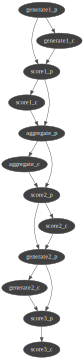

In [3]:
train_df = pandas.read_csv('post_docmerge_train.csv')
df = pandas.read_csv('post_docmerge.csv')

template=gum.BayesNet()
template.add(gum.RangeVariable("generate1_p", "generate1_p",int(np.min(list(df['generate1_p'].to_dict().values()))), int(np.max(list(df['generate1_p'].to_dict().values())))))
template.add(gum.RangeVariable("generate1_c", "generate1_c",int(np.min(list(df['generate1_c'].to_dict().values()))), int(np.max(list(df['generate1_c'].to_dict().values())))))
template.add(gum.RangeVariable("score1_p", "score1_p",int(np.min(list(df['score1_p'].to_dict().values()))), int(np.max(list(df['score1_p'].to_dict().values())))))
template.add(gum.RangeVariable("score1_c", "score1_c",int(np.min(list(df['score1_c'].to_dict().values()))), int(np.max(list(df['score1_c'].to_dict().values())))))
template.add(gum.RangeVariable("aggregate_p", "aggregate_p",int(np.min(list(df['aggregate_p'].to_dict().values()))), int(np.max(list(df['aggregate_p'].to_dict().values())))))
template.add(gum.RangeVariable("aggregate_c", "aggregate_c",int(np.min(list(df['aggregate_c'].to_dict().values()))), int(np.max(list(df['aggregate_c'].to_dict().values())))))
template.add(gum.RangeVariable("score2_p", "score2_p",int(np.min(list(df['score2_p'].to_dict().values()))), int(np.max(list(df['score2_p'].to_dict().values())))))
template.add(gum.RangeVariable("score2_c", "score2_c",int(np.min(list(df['score2_c'].to_dict().values()))), int(np.max(list(df['score2_c'].to_dict().values())))))
template.add(gum.RangeVariable("generate2_p", "generate2_p",int(np.min(list(df['generate2_p'].to_dict().values()))), int(np.max(list(df['generate2_p'].to_dict().values())))))
template.add(gum.RangeVariable("generate2_c", "generate2_c",int(np.min(list(df['generate2_c'].to_dict().values()))), int(np.max(list(df['generate2_c'].to_dict().values())))))
template.add(gum.RangeVariable("score3_p", "score3_p",int(np.min(list(df['score3_p'].to_dict().values()))), int(np.max(list(df['score3_p'].to_dict().values())))))
template.add(gum.RangeVariable("score3_c", "score3_c",int(np.min(list(df['score3_c'].to_dict().values()))), int(np.max(list(df['score3_c'].to_dict().values())))))
# template.add(gum.RangeVariable("task_time", "task_time",int(np.min(list(train_df['task_time'].to_dict().values()))), int(np.max(list(train_df['task_time'].to_dict().values())))))
for link in [('generate1_p','generate1_c'),('generate1_c','score1_p'),('score1_p','score1_c'),('score1_c','aggregate_p'),('aggregate_p','aggregate_c'),('aggregate_c','score2_p'),('score2_p','score2_c'),('score2_c','generate2_p'),('generate2_p','generate2_c'),('generate2_c','score3_p'),('score3_p','score3_c'),
             ('generate1_p','score1_p'),('score1_p','aggregate_p'),('aggregate_p','score2_p'),('score2_p','generate2_p'),('generate2_p','score3_p')]:
    template.addArc(*link)
gnb.showBN(template)
# print(template['generate1_p'])

In [4]:
import time 
s = time.time()
learner = gum.BNLearner(df, template)
# learner = gum.BNLearner(df, template)
# # bn1 = learner.learnBN()
# # bn1

learner.useSmoothingPrior(1) 
template = learner.learnParameters(template) 
e = time.time()
print(e-s)
# print(template.cpt('score3_p'))
gum.saveBN(template,"/workspace/Bayes/got_docmerge.bif")


0.030004501342773438


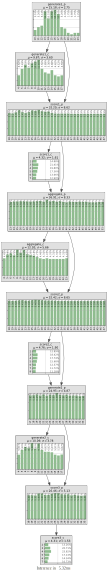

In [5]:
gnb.showInference(template)

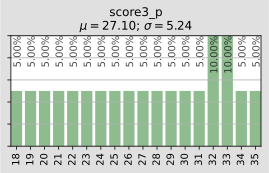

In [6]:
gnb.showPosterior(template, evs={'generate2_p': '31','generate2_c': '14'}, target="score3_p")
# evs={"generate1_p": '17','generate1_c': '14','score1_p': '34', 'score1_c': '3', 'aggregate_p': '44','aggregate_c': '12','score2_p': '32','score2_c': '4','generate2_p': '31','generate2_c': '14'}

# Test

{'generate1_p': 6.0, 'generate1_c': 10.0, 'score1_p': 22.0, 'score1_c': 0.0, 'aggregate_p': 51.0, 'aggregate_c': 15.0, 'score2_p': 17.0, 'score2_c': 0.0, 'generate2_p': 17.0, 'generate2_c': 15.0, 'score3_p': 17.0, 'score3_c': 1.0}
{'generate1_c': 12.0, 'score1_p': 13.0, 'score1_c': 0.0, 'aggregate_p': 51.0, 'aggregate_c': 15.0, 'score2_p': 17.0, 'score2_c': 0.0, 'generate2_p': 17.0, 'generate2_c': 15.0, 'score3_p': 17.0, 'score3_c': 1.0}
{'score1_p': 0.0, 'score1_c': 0.0, 'aggregate_p': 45.0, 'aggregate_c': 15.0, 'score2_p': 17.0, 'score2_c': 0.0, 'generate2_p': 17.0, 'generate2_c': 15.0, 'score3_p': 17.0, 'score3_c': 1.0}
{'score1_c': 0.0, 'aggregate_p': 3.0, 'aggregate_c': 11.0, 'score2_p': 17.0, 'score2_c': 0.0, 'generate2_p': 17.0, 'generate2_c': 15.0, 'score3_p': 17.0, 'score3_c': 1.0}
{'aggregate_p': 1.0, 'aggregate_c': 11.0, 'score2_p': 13.0, 'score2_c': 0.0, 'generate2_p': 17.0, 'generate2_c': 15.0, 'score3_p': 17.0, 'score3_c': 1.0}
{'aggregate_c': 1.0, 'score2_p': 0.0, 'score

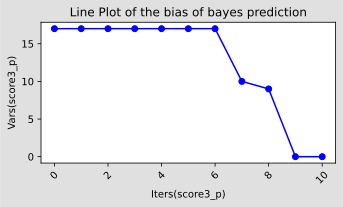

<Figure size 640x480 with 0 Axes>

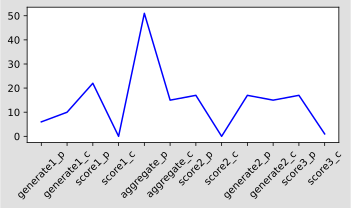

In [7]:
bn = gum.loadBN('/workspace/Bayes/got_docmerge.bif')
_ , test_df = train_test_split(df, test_size=0.1, random_state=42)
stage_list = ["generate1_p",'generate1_c','score1_p', 'score1_c', 'aggregate_p','aggregate_c','score2_p','score2_c','generate2_p','generate2_c','score3_p', 'score3_c', ]

plot(stage_list, test_df, 10)

In [8]:
def single_evaluate(bn, target, hnown_list):
    def init_belief(engine, target, hnown_list):
        # Initialize evidence
        for var in hnown_list:
        # for var in engine.BN().names():
            if var != target:
                engine.addEvidence(var, 0)

    def update_beliefs(engine, bayesNet, row, target, hnown_list):
        # Update beliefs from a given row less the Survived variable
        for var in hnown_list:
        # for var in bayesNet.names():
            if var == target:
                continue
            try:
                label = str(row.to_dict()[var])
                print(label)
                idx = bayesNet.variable(var).index(str(row.to_dict()[var]))
                # print(f"{bayesNet.variable(idx)=}")
                engine.chgEvidence(var, idx)
            except gum.NotFound:
                # this can happend when value is missing is the test base.
                pass        
        engine.makeInference()
        
    def is_well_predicted(engine, bayesNet, auc, row, target, hnown_list):
        update_beliefs(engine, bayesNet, row, target, hnown_list)
        marginal = engine.posterior(target)
        # print(marginal.toarray())
        outcome = row.to_dict()[target]
        # print(np.where(marginal.toarray()==np.max(marginal.toarray())))
        exp = np.mean(np.where(marginal.toarray()==np.max(marginal.toarray())))
        # exp = np.mean(np.where(marginal.toarray()>auc))
        return(exp + np.min([int(i) for i in list(bayesNet[target].labels())]) - outcome)**2
        # return 0
    ie=gum.LazyPropagation(bn)
    init_belief(ie, target, hnown_list)
    ie.addTarget(target)
    result = test_df.apply(lambda x: is_well_predicted(ie, bn, 1/14, x, target, hnown_list), axis=1)
    return result.mean()
    # return list(result)
import time
s = time.time()
print(single_evaluate(bn, 'score3_p', ["generate1_p",'generate1_c','score1_p', 'score1_c', 'aggregate_p','aggregate_c','score2_p','score2_c','generate2_p','generate2_c']))
e = time.time()
print(e-s)

14
11
30
3
38
13
29
3
28
13
13
12
27
3
38
12
27
3
25
12
14
10
26
4
34
9
26
4
24
10
17
8
27
4
34
8
27
4
25
8
15
13
30
2
42
13
30
2
28
13
13
7
21
3
28
8
22
3
21
8
17
17
35
3
50
17
35
3
33
17
11
7
19
4
26
8
21
3
19
8
15
8
25
5
33
9
26
4
23
8
13
6
21
3
26
6
21
3
19
6
0.225
0.015169858932495117


# Other models : factool_code

In [9]:
with open('/workspace/Hermes/Datasets/factool/code/token.json', 'r') as f:
    raw = json.load(f)

data = {}

data['generate_queries_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in ['0'] ])/40) for p in raw.values()]
print(data['generate_queries_p'])
print(np.max(data['generate_queries_p'])-np.min(data['generate_queries_p']))

data['generate_queries_c'] = [int(np.mean([p[k]['completion_tokens'] for k in ['0'] ])/20) for p in raw.values()]
print(data['generate_queries_c'])
print(np.max(data['generate_queries_c'])-np.min(data['generate_queries_c']))

data['generate_solutions_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in ['1','2','3'] ])/40) for p in raw.values()]
print(data['generate_solutions_p'])
print(np.max(data['generate_solutions_p'])-np.min(data['generate_solutions_p']))

data['generate_solutions_c'] = [int(np.mean([p[k]['completion_tokens'] for k in ['1', '2', '3'] ])/40) for p in raw.values()]
print(data['generate_solutions_c'])
print(np.max(data['generate_solutions_c'])-np.min(data['generate_solutions_c']))

df = pandas.DataFrame(data)
df.to_csv('/workspace/Bayes/post_factool_code.csv')

KeyError: '0'

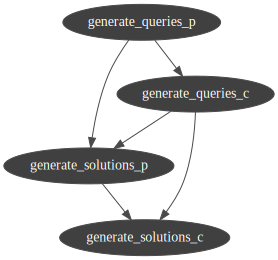

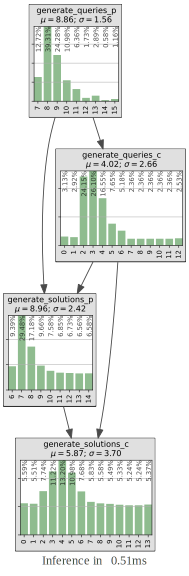

In [10]:
df = pandas.read_csv('post_factool_code.csv')

template=gum.BayesNet()
template.add(gum.RangeVariable("generate_queries_p", "generate_queries_p",int(np.min(list(df['generate_queries_p'].to_dict().values()))), int(np.max(list(df['generate_queries_p'].to_dict().values())))))
template.add(gum.RangeVariable("generate_queries_c", "generate_queries_c",int(np.min(list(df['generate_queries_c'].to_dict().values()))), int(np.max(list(df['generate_queries_c'].to_dict().values())))))
template.add(gum.RangeVariable("generate_solutions_p", "generate_solutions_p",int(np.min(list(df['generate_solutions_p'].to_dict().values()))), int(np.max(list(df['generate_solutions_p'].to_dict().values())))))
template.add(gum.RangeVariable("generate_solutions_c", "generate_solutions_c",int(np.min(list(df['generate_solutions_c'].to_dict().values()))), int(np.max(list(df['generate_solutions_c'].to_dict().values())))))

for link in [('generate_queries_p','generate_queries_c'),('generate_queries_c','generate_solutions_p'),('generate_solutions_p','generate_solutions_c'),
             ('generate_queries_p','generate_solutions_p'),('generate_queries_c','generate_solutions_c')]:
    template.addArc(*link)
gnb.showBN(template)

learner = gum.BNLearner(df, template)
learner.useSmoothingPrior(1) 
template = learner.learnParameters(template) 

gum.saveBN(template,"/workspace/Bayes/factool_code.bif")

gnb.showInference(template)

{'generate_queries_p': '0.7', 'generate_queries_c': '1.5', 'generate_solutions_p': '0.8', 'generate_solutions_c': '6.6'}
{'generate_queries_c': '1.6', 'generate_solutions_p': '0.1', 'generate_solutions_c': '5.2'}
{'generate_solutions_p': '0.1', 'generate_solutions_c': '5.1'}
{'generate_solutions_c': '5.1'}
[{'generate_queries_p': '0.7', 'generate_queries_c': '1.5', 'generate_solutions_p': '0.8', 'generate_solutions_c': '6.6'}, {'generate_queries_c': '1.6', 'generate_solutions_p': '0.1', 'generate_solutions_c': '5.2'}, {'generate_solutions_p': '0.1', 'generate_solutions_c': '5.1'}, {'generate_solutions_c': '5.1'}]


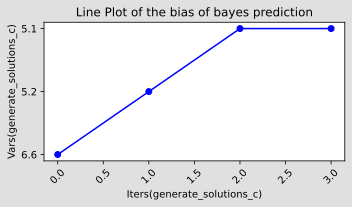

<Figure size 640x480 with 0 Axes>

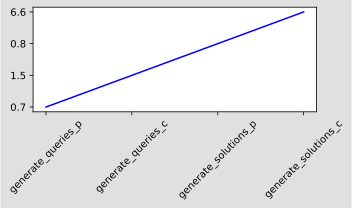

In [11]:
bn = gum.loadBN('/workspace/Bayes/factool_code.bif')
_, test_df =  train_test_split(df, test_size=0.1, random_state=88)
stage_list = ["generate_queries_p","generate_queries_c","generate_solutions_p","generate_solutions_c" ]

plot(stage_list, test_df, 3)

# factool_kbqa

In [12]:
with open('/workspace/Hermes/Datasets/factool/kbqa/token.json', 'r') as f:
    raw = json.load(f)

data = {}

data['extract_claims_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in ['0'] ])/40) for p in raw.values()]
print(data['extract_claims_p'])
print(np.max(data['extract_claims_p'])-np.min(data['extract_claims_p']))

data['extract_claims_c'] = [int(np.mean([p[k]['completion_tokens'] for k in ['0'] ])/20) for p in raw.values()]
print(data['extract_claims_c'])
print(np.max(data['extract_claims_c'])-np.min(data['extract_claims_c']))

data['generate_queries_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in [str(i) for i in range(1, 1+ int(len(list(p.keys()))/2) ) ] ])/10) for p in raw.values()]
print(data['generate_queries_p'])
print(np.max(data['generate_queries_p'])-np.min(data['generate_queries_p']))

data['generate_queries_c'] = [int(np.mean([p[k]['completion_tokens'] for k in [str(i) for i in range(1, 1+ int(len(list(p.keys()))/2) ) ] ])/10) for p in raw.values()]
print(data['generate_queries_c'])
print(np.max(data['generate_queries_c'])-np.min(data['generate_queries_c']))

data['verifies_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in [str(i) for i in range(1+int(len(list(p.keys()))/2), int(len(list(p.keys()))) ) ] ])/40) for p in raw.values()]
print(data['verifies_p'])
print(np.max(data['verifies_p'])-np.min(data['verifies_p']))

data['verifies_c'] = [int(np.mean([p[k]['completion_tokens'] for k in [str(i) for i in range(1+int(len(list(p.keys()))/2), int(len(list(p.keys()))) ) ] ])/10) for p in raw.values()]
print(data['verifies_c'])
print(np.max(data['verifies_c'])-np.min(data['verifies_c']))

df = pandas.DataFrame(data)
df.to_csv('/workspace/Bayes/post_factool_kbqa.csv')

[18, 19, 18, 18, 19, 18, 18, 21, 18, 20, 18, 17, 17, 17, 17, 18, 18, 17, 17, 18, 21, 22, 17, 17, 17, 17, 18, 18, 19, 20, 19, 20, 17, 19, 18, 17, 17, 17, 17, 17, 17, 18, 18, 17, 18, 17, 18, 17, 17, 18]
5
[5, 8, 5, 5, 11, 4, 5, 11, 6, 7, 4, 2, 3, 3, 2, 4, 4, 2, 2, 6, 9, 11, 2, 3, 3, 2, 7, 4, 6, 8, 12, 12, 2, 7, 5, 3, 2, 1, 3, 3, 1, 3, 4, 2, 3, 3, 6, 2, 2, 4]
11
[36, 36, 36, 37, 36, 37, 37, 37, 37, 36, 37, 37, 36, 36, 37, 37, 36, 37, 37, 36, 36, 37, 36, 36, 36, 37, 36, 36, 37, 36, 37, 36, 36, 36, 36, 36, 36, 37, 36, 37, 36, 37, 37, 37, 37, 36, 37, 36, 36, 36]
1
[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 2, 2, 2, 1, 2, 1, 3, 2, 2, 2, 1, 2, 3, 2, 1, 2, 2, 2, 1]
2
[14, 14, 12, 16, 13, 14, 18, 13, 14, 13, 14, 13, 12, 14, 13, 14, 14, 15, 16, 14, 15, 12, 14, 15, 13, 16, 13, 14, 17, 15, 18, 16, 12, 17, 12, 12, 11, 11, 14, 13, 13, 11, 15, 12, 15, 17, 14, 13, 16, 13]
7
[14, 15, 14, 17, 17, 18, 16, 17, 19, 16, 18, 12, 15, 13, 13, 16, 16, 21, 24, 15

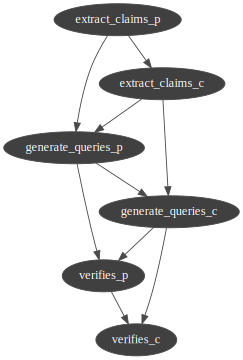

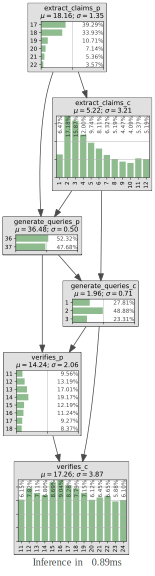

In [13]:
df = pandas.read_csv('post_factool_kbqa.csv')

template=gum.BayesNet()
template.add(gum.RangeVariable("extract_claims_p", "extract_claims_p",int(np.min(list(df['extract_claims_p'].to_dict().values()))), int(np.max(list(df['extract_claims_p'].to_dict().values())))))
template.add(gum.RangeVariable("extract_claims_c", "extract_claims_c",int(np.min(list(df['extract_claims_c'].to_dict().values()))), int(np.max(list(df['extract_claims_c'].to_dict().values())))))
template.add(gum.RangeVariable("generate_queries_p", "generate_queries_p",int(np.min(list(df['generate_queries_p'].to_dict().values()))), int(np.max(list(df['generate_queries_p'].to_dict().values())))))
template.add(gum.RangeVariable("generate_queries_c", "generate_queries_c",int(np.min(list(df['generate_queries_c'].to_dict().values()))), int(np.max(list(df['generate_queries_c'].to_dict().values())))))
template.add(gum.RangeVariable("verifies_p", "verifies_p",int(np.min(list(df['verifies_p'].to_dict().values()))), int(np.max(list(df['verifies_p'].to_dict().values())))))
template.add(gum.RangeVariable("verifies_c", "verifies_c",int(np.min(list(df['verifies_c'].to_dict().values()))), int(np.max(list(df['verifies_c'].to_dict().values())))))

for link in [('extract_claims_p','extract_claims_c'),('extract_claims_c','generate_queries_p'),('generate_queries_p','generate_queries_c'),('generate_queries_c', 'verifies_p'), ('verifies_p', 'verifies_c'),
             ('extract_claims_p','generate_queries_p'),('generate_queries_p', 'verifies_p'),
             ('extract_claims_c','generate_queries_c'),('generate_queries_c', 'verifies_c')]:
    template.addArc(*link)
gnb.showBN(template)

learner = gum.BNLearner(df, template)
learner.useSmoothingPrior(1) 
template = learner.learnParameters(template) 

gum.saveBN(template,"/workspace/Bayes/factool_kbqa.bif")

gnb.showInference(template)

{'extract_claims_p': '0.4', 'extract_claims_c': '2.8', 'generate_queries_p': '0.2', 'generate_queries_c': '0.6', 'verifies_p': '3.0', 'verifies_c': '11.2'}
{'extract_claims_c': '0.4', 'generate_queries_p': '0.6', 'generate_queries_c': '0.6', 'verifies_p': '3.0', 'verifies_c': '11.2'}
{'generate_queries_p': '0.4', 'generate_queries_c': '0.6', 'verifies_p': '3.0', 'verifies_c': '11.2'}
{'generate_queries_c': '0.5', 'verifies_p': '3.0', 'verifies_c': '13.2'}
{'verifies_p': '2.6', 'verifies_c': '9.2'}
{'verifies_c': '2.6'}
[{'extract_claims_p': '0.4', 'extract_claims_c': '2.8', 'generate_queries_p': '0.2', 'generate_queries_c': '0.6', 'verifies_p': '3.0', 'verifies_c': '11.2'}, {'extract_claims_c': '0.4', 'generate_queries_p': '0.6', 'generate_queries_c': '0.6', 'verifies_p': '3.0', 'verifies_c': '11.2'}, {'generate_queries_p': '0.4', 'generate_queries_c': '0.6', 'verifies_p': '3.0', 'verifies_c': '11.2'}, {'generate_queries_c': '0.5', 'verifies_p': '3.0', 'verifies_c': '13.2'}, {'verifies

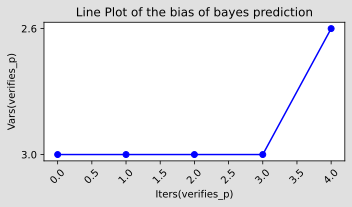

<Figure size 640x480 with 0 Axes>

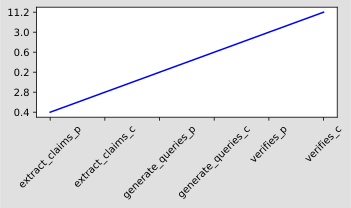

In [14]:
bn = gum.loadBN('/workspace/Bayes/factool_kbqa.bif')
_, test_df =  train_test_split(df, test_size=0.1, random_state=88)
stage_list =  ["extract_claims_p","extract_claims_c","generate_queries_p","generate_queries_c","verifies_p","verifies_c"]

plot(stage_list, test_df, 4)

# fantool math

In [15]:
with open('/workspace/Hermes/Datasets/factool/math/token.json', 'r') as f:
    raw = json.load(f)

data = {}

data['extract_claims_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in ['0'] ])/40) for p in raw.values()]
print(data['extract_claims_p'])
print(np.max(data['extract_claims_p'])-np.min(data['extract_claims_p']))

data['extract_claims_c'] = [int(np.mean([p[k]['completion_tokens'] for k in ['0'] ])/20) for p in raw.values()]
print(data['extract_claims_c'])
print(np.max(data['extract_claims_c'])-np.min(data['extract_claims_c']))

data['generate_queries_p'] = [int(np.mean([p[k]['prompt_tokens'] for k in [str(i) for i in range(1, int(len(list(p.keys()))) ) ] ])/10) for p in raw.values()]
print(data['generate_queries_p'])
print(np.max(data['generate_queries_p'])-np.min(data['generate_queries_p']))

data['generate_queries_c'] = [int(np.mean([p[k]['completion_tokens'] for k in [str(i) for i in range(1, int(len(list(p.keys()))) ) ] ])/10) for p in raw.values()]
print(data['generate_queries_c'])
print(np.max(data['generate_queries_c'])-np.min(data['generate_queries_c']))

df = pandas.DataFrame(data)
df.to_csv('/workspace/Bayes/post_factool_math.csv')

[18, 18, 27, 21, 22, 20, 20, 21, 19, 21, 19, 19, 25, 20, 20, 19, 22, 19, 21, 18, 19, 23, 24, 18, 20, 20, 22, 25, 19, 19, 21, 20, 22, 22, 18, 21, 20, 20, 20, 19, 20, 22, 20, 23, 19, 20, 20, 22, 21, 20, 18, 19, 21, 18, 20, 22, 21, 21, 21, 24, 18, 21, 20, 20, 20, 21, 20, 22, 19, 18, 25, 28, 20, 19, 19, 21, 18, 22, 19, 19, 23, 20, 19, 22, 20, 19, 21, 19, 24, 21, 19, 20, 18, 20, 22, 20, 20, 20, 19, 18]
10
[3, 3, 4, 6, 7, 6, 6, 3, 3, 3, 1, 1, 10, 7, 4, 3, 3, 5, 6, 3, 3, 1, 1, 2, 3, 4, 7, 12, 5, 5, 3, 3, 3, 7, 3, 4, 6, 6, 2, 3, 3, 5, 3, 9, 1, 5, 6, 8, 4, 5, 1, 3, 4, 3, 3, 5, 7, 6, 4, 1, 2, 4, 5, 3, 7, 3, 4, 6, 3, 3, 3, 15, 4, 2, 3, 7, 4, 1, 3, 3, 7, 5, 3, 9, 3, 3, 5, 3, 14, 6, 3, 4, 4, 4, 3, 3, 6, 3, 4, 2]
14
[27, 26, 27, 27, 27, 27, 26, 26, 26, 27, 26, 25, 27, 26, 26, 25, 26, 25, 27, 26, 26, 25, 25, 25, 26, 26, 27, 27, 27, 26, 25, 26, 26, 27, 26, 27, 27, 27, 25, 25, 27, 27, 26, 27, 25, 27, 27, 26, 26, 26, 26, 27, 26, 26, 26, 27, 26, 27, 26, 26, 25, 25, 26, 25, 27, 26, 26, 26, 26, 26, 26, 26,

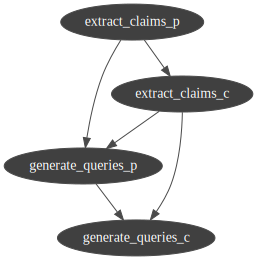

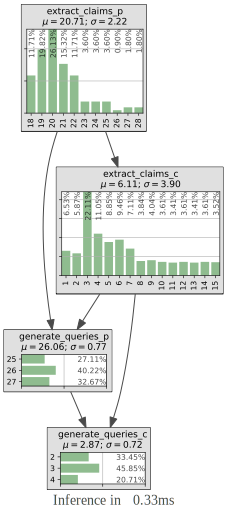

In [16]:
df = pandas.read_csv('post_factool_math.csv')

template=gum.BayesNet()
template.add(gum.RangeVariable("extract_claims_p", "extract_claims_p",int(np.min(list(df['extract_claims_p'].to_dict().values()))), int(np.max(list(df['extract_claims_p'].to_dict().values())))))
template.add(gum.RangeVariable("extract_claims_c", "extract_claims_c",int(np.min(list(df['extract_claims_c'].to_dict().values()))), int(np.max(list(df['extract_claims_c'].to_dict().values())))))
template.add(gum.RangeVariable("generate_queries_p", "generate_queries_p",int(np.min(list(df['generate_queries_p'].to_dict().values()))), int(np.max(list(df['generate_queries_p'].to_dict().values())))))
template.add(gum.RangeVariable("generate_queries_c", "generate_queries_c",int(np.min(list(df['generate_queries_c'].to_dict().values()))), int(np.max(list(df['generate_queries_c'].to_dict().values())))))

for link in [('extract_claims_p','extract_claims_c'),('extract_claims_c','generate_queries_p'),('generate_queries_p','generate_queries_c'),
             ('extract_claims_p','generate_queries_p'),
             ('extract_claims_c','generate_queries_c'),]:
    template.addArc(*link)
gnb.showBN(template)

learner = gum.BNLearner(df, template)
learner.useSmoothingPrior(1) 
template = learner.learnParameters(template) 

gum.saveBN(template,"/workspace/Bayes/factool_math.bif")

gnb.showInference(template)

{'extract_claims_p': '6.7', 'extract_claims_c': '4.1', 'generate_queries_p': '0.6', 'generate_queries_c': '0.3'}
{'extract_claims_c': '1.1', 'generate_queries_p': '0.7', 'generate_queries_c': '0.3'}
{'generate_queries_p': '0.3', 'generate_queries_c': '0.3'}
{'generate_queries_c': '0.2'}
[{'extract_claims_p': '6.7', 'extract_claims_c': '4.1', 'generate_queries_p': '0.6', 'generate_queries_c': '0.3'}, {'extract_claims_c': '1.1', 'generate_queries_p': '0.7', 'generate_queries_c': '0.3'}, {'generate_queries_p': '0.3', 'generate_queries_c': '0.3'}, {'generate_queries_c': '0.2'}]


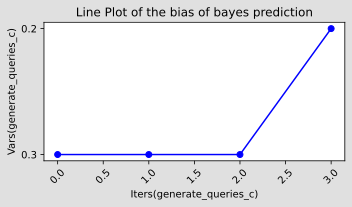

<Figure size 640x480 with 0 Axes>

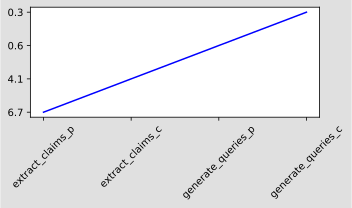

In [17]:
bn = gum.loadBN('/workspace/Bayes/factool_math.bif')
_, test_df =  train_test_split(df, test_size=0.1, random_state=88)
stage_list =  ["extract_claims_p","extract_claims_c","generate_queries_p","generate_queries_c"]

plot(stage_list, test_df, 3)